In [141]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import relativedelta
import xgboost as xgb
from typing import Tuple
import re
#from xgboost import XGBClassifier
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip, geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot, coord_cartesian, scale_color_manual, labs

In [142]:
pd.set_option('display.max_columns', None)

In [143]:
data_path = Path("../data")

In [144]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [145]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df = df[column_order]
df['churn'] = df['churn'].astype(int)

In [146]:
df = df.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

delete  columns with a lot of importance

In [147]:
#df = df.drop(['months_since_last_contract'], axis=1)       # para eliminar la columna de months_since_last_contract

df = df.drop(['months_since_last_contract', 'tenure'], axis=1)   # para eliminar la columna de months_since_last_contract y tenure
#df = df.drop(['months_since_last_contract', 'tenure', 'has_renewed'], axis=1)    # para eliminar la columna de months_since_last_contract , tenure y has_renewed

La celda a continuacion hay que comentarla cuando no usemos la columna months_since_last_contract

In [148]:
'''
ids_with_nan_months_since_last_contract = df[
    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]
'''

"\nids_with_nan_months_since_last_contract = df[\n    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]\n"

La celda a continuacion hay que comentarla cuando no usemos la columna tenure

In [149]:
'''
ids_with_nan_tenure = df[
    df['tenure'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]
'''

"\nids_with_nan_tenure = df[\n    df['tenure'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]\n"

In [150]:
def split_train_test_by_period(data_set, execution_date):
    train_end_date = execution_date + relativedelta(months=6)
    val_date = execution_date + relativedelta(months=7)

    train_start_str = execution_date.strftime('%Y%m')
    train_end_str = train_end_date.strftime('%Y%m')
    val_str = val_date.strftime('%Y%m')

    train_set = data_set[
        (data_set['month_period'] >= train_start_str) &
        (data_set['month_period'] <= train_end_str)
    ]
    test_set = data_set[data_set['month_period'] == val_str]

    return train_set, test_set

In [151]:
all_results = {}
all_predicted_clients_list = []
all_models = {}

In [152]:
import warnings
warnings.filterwarnings('ignore')


def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.01,
        "max_depth": 3,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "nthread": 10,
        "random_state": 1
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=[(dtest, "eval"), (dtrain, "train")],
        early_stopping_rounds=20,
        verbose_eval=False,
        evals_result=evals_result
    )


    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df.index.name = 'feature'
    importance_df.reset_index(inplace=True)


    return model, evals_result, importance_df

In [153]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_clients_list, all_models, n_estimators):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(df, execution_date)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, importance_df = train_model(train_set, test_set, n_estimators = n_estimators)

            importance_df["execution_date"] = execution_date

            
            test_set['prob'] = model.predict(xgb.DMatrix(test_set.drop(columns="churn")))
            predicted_clients = test_set.sort_values('prob', ascending = False)
            predicted_clients["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_clients_list.append(predicted_clients)

        return all_results, all_models, importance_df, all_predicted_clients_list

In [154]:
def train_model_across_periods(n_estimators):
    global all_results
    global all_models
    global all_predicted_clients_list
    global final_importance_df

    feature_importance_list = []

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_models, importance_df, all_predicted_clients_list = run_model_for_execution_date(
            current_date, all_results, all_predicted_clients_list ,all_models, n_estimators
        )

        feature_importance_list.append(importance_df)

        current_date += relativedelta(months=1)
    
    final_importance_df = pd.concat(feature_importance_list, ignore_index=True)

#train_model_across_periods(n_estimators=params["n_estimators"])

In [155]:
def return_learning_curve(set_name):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(['execution_date'])
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(learning_curves, first_metric, on=["execution_date"])
            learning_curves["norm_" + column] = (learning_curves[column] - learning_curves["first_" + column]) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

In [156]:
train_model_across_periods(n_estimators=200)

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


# Ver la probabilidad de churn 

In [157]:
all_predicted_clients = pd.concat(all_predicted_clients_list)
all_predicted_clients[['advertiser_zrive_id', 'period_int', 'churn', 'prob', 'execution_date']]

,advertiser_zrive_id,period_int,churn,prob,execution_date
25507,3063,202310,0,0.228620,2023-03-01
25926,4348,202310,0,0.227876,2023-03-01
26130,5159,202310,0,0.227790,2023-03-01
25474,2972,202310,0,0.227655,2023-03-01
25462,2926,202310,1,0.227636,2023-03-01
...,...,...,...,...,...
53153,2621,202411,0,0.023454,2024-04-01
53420,3521,202411,0,0.023421,2024-04-01
53443,3601,202411,0,0.022067,2024-04-01
53449,3614,202411,0,0.021723,2024-04-01


In [158]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [159]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

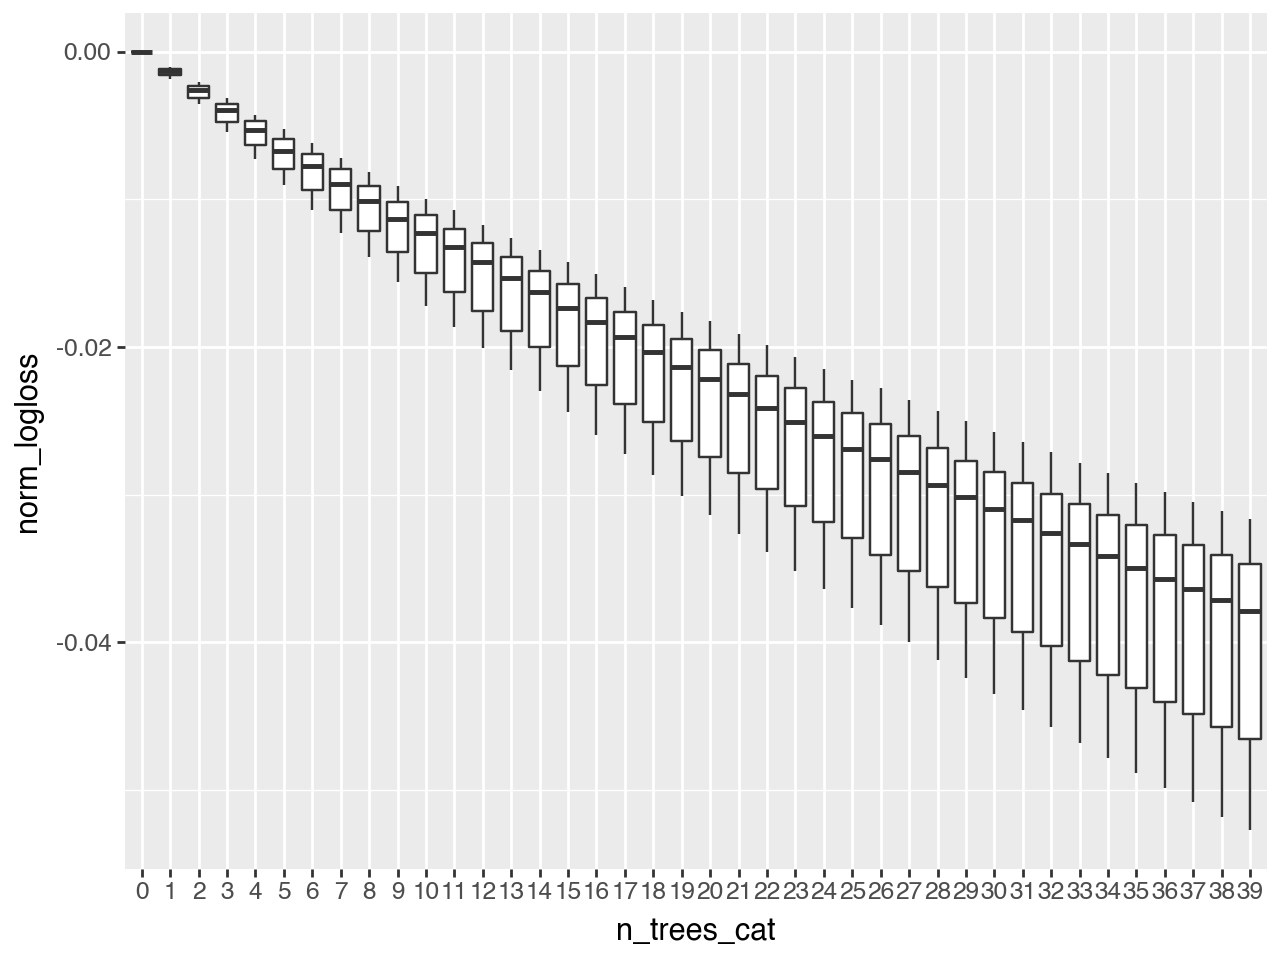

In [160]:
ggplot(train_lc[train_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

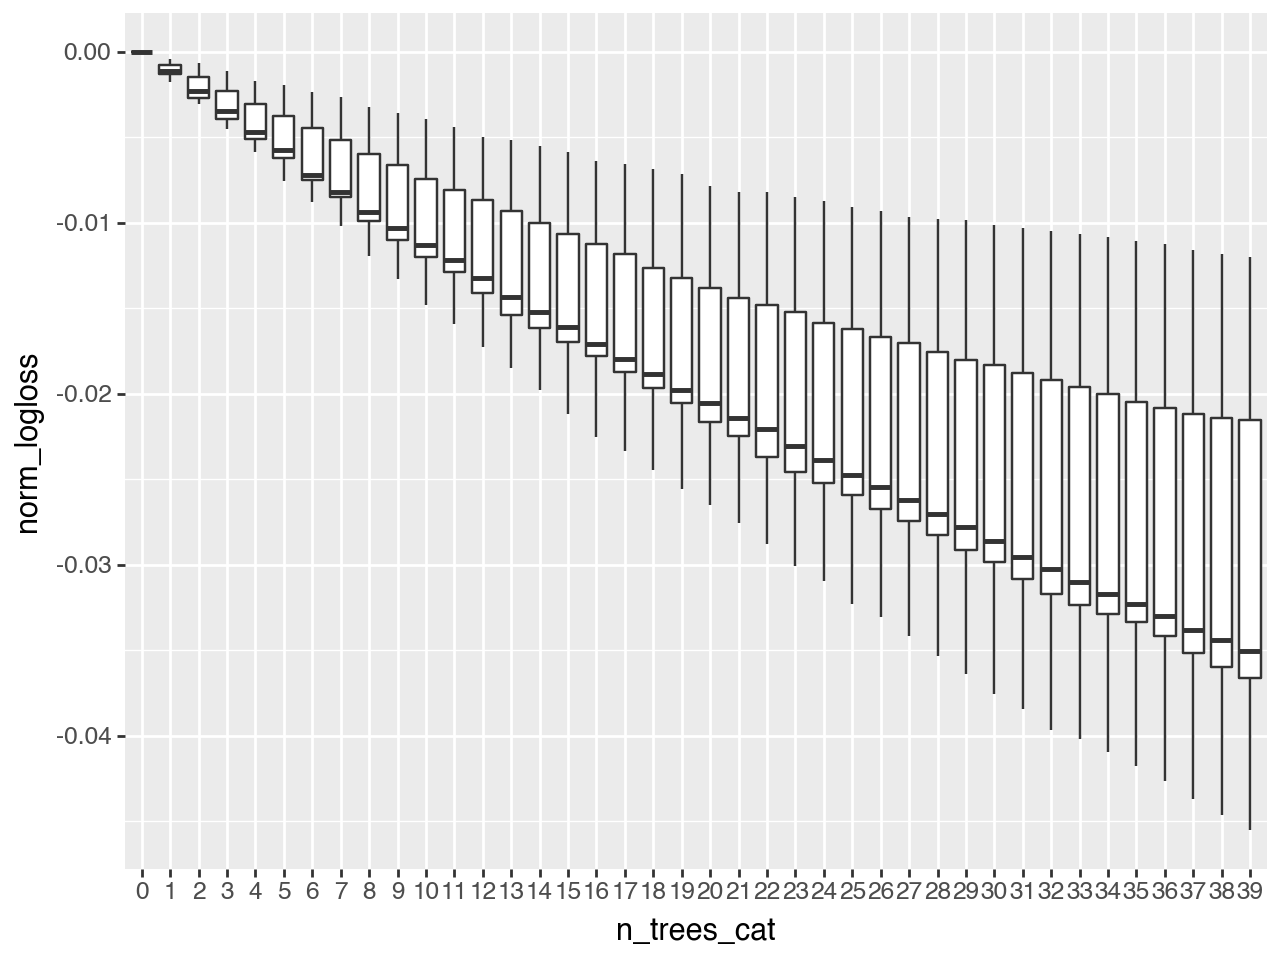

In [161]:
ggplot(test_lc[test_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

In [162]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

filtered_train_lc = train_lc[train_lc["n_trees"] % 10 == 0].copy()
filtered_test_lc = test_lc[test_lc["n_trees"] % 10 == 0].copy()

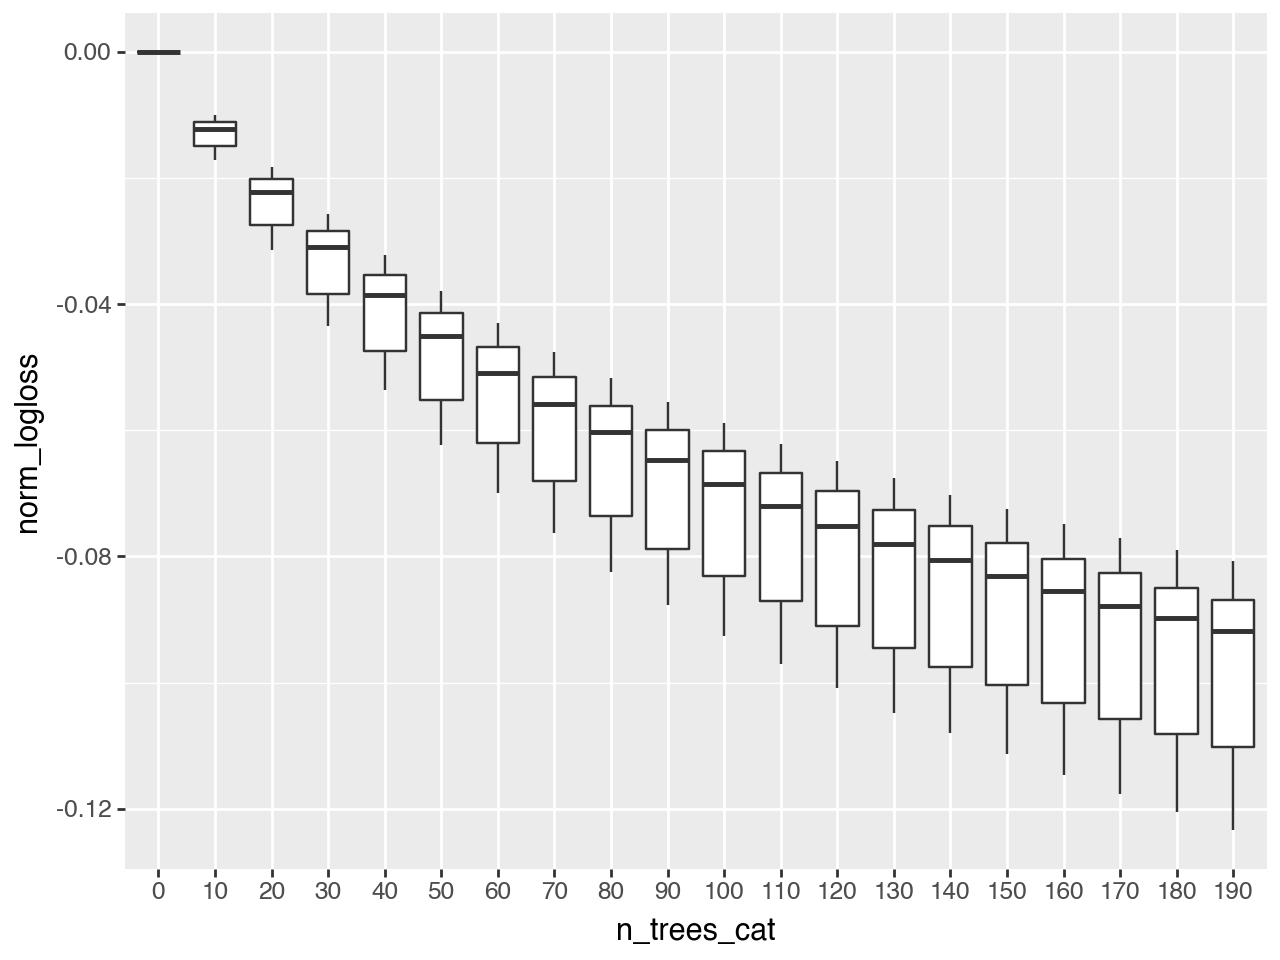

In [163]:
ggplot(filtered_train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

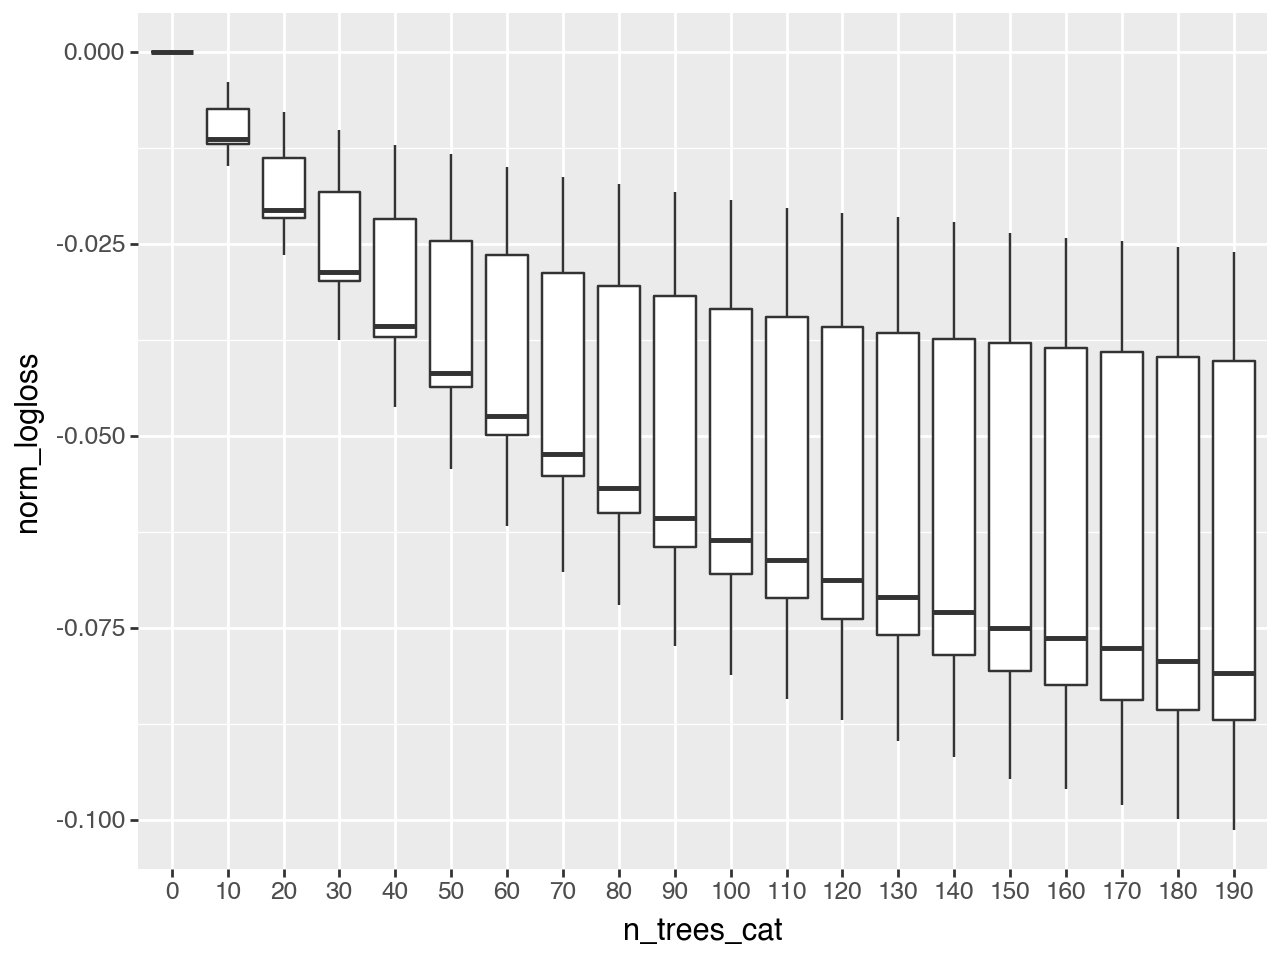

In [164]:
ggplot(filtered_test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

<Figure size 1000x600 with 0 Axes>

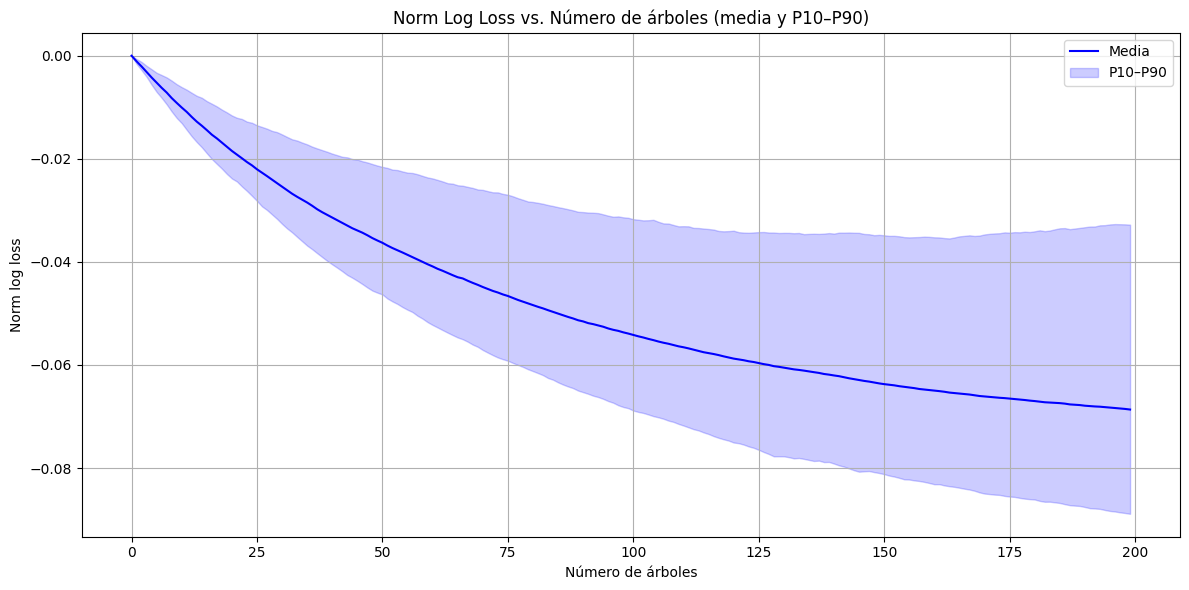

In [165]:
summary = test_lc.groupby("n_trees")["norm_logloss"].agg(
    mean="mean",
    p10=lambda x: x.quantile(0.10),
    p90=lambda x: x.quantile(0.90)
).reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(summary["n_trees"], summary["mean"], label="Media", color="blue")
plt.fill_between(summary["n_trees"], summary["p10"], summary["p90"], color="blue", alpha=0.2, label="P10–P90")
plt.xlabel("Número de árboles")
plt.ylabel("Norm log loss")
plt.title("Norm Log Loss vs. Número de árboles (media y P10–P90)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:
train_lc["set"] = "train"
test_lc["set"] = "test"

data_lc = pd.concat([train_lc, test_lc])

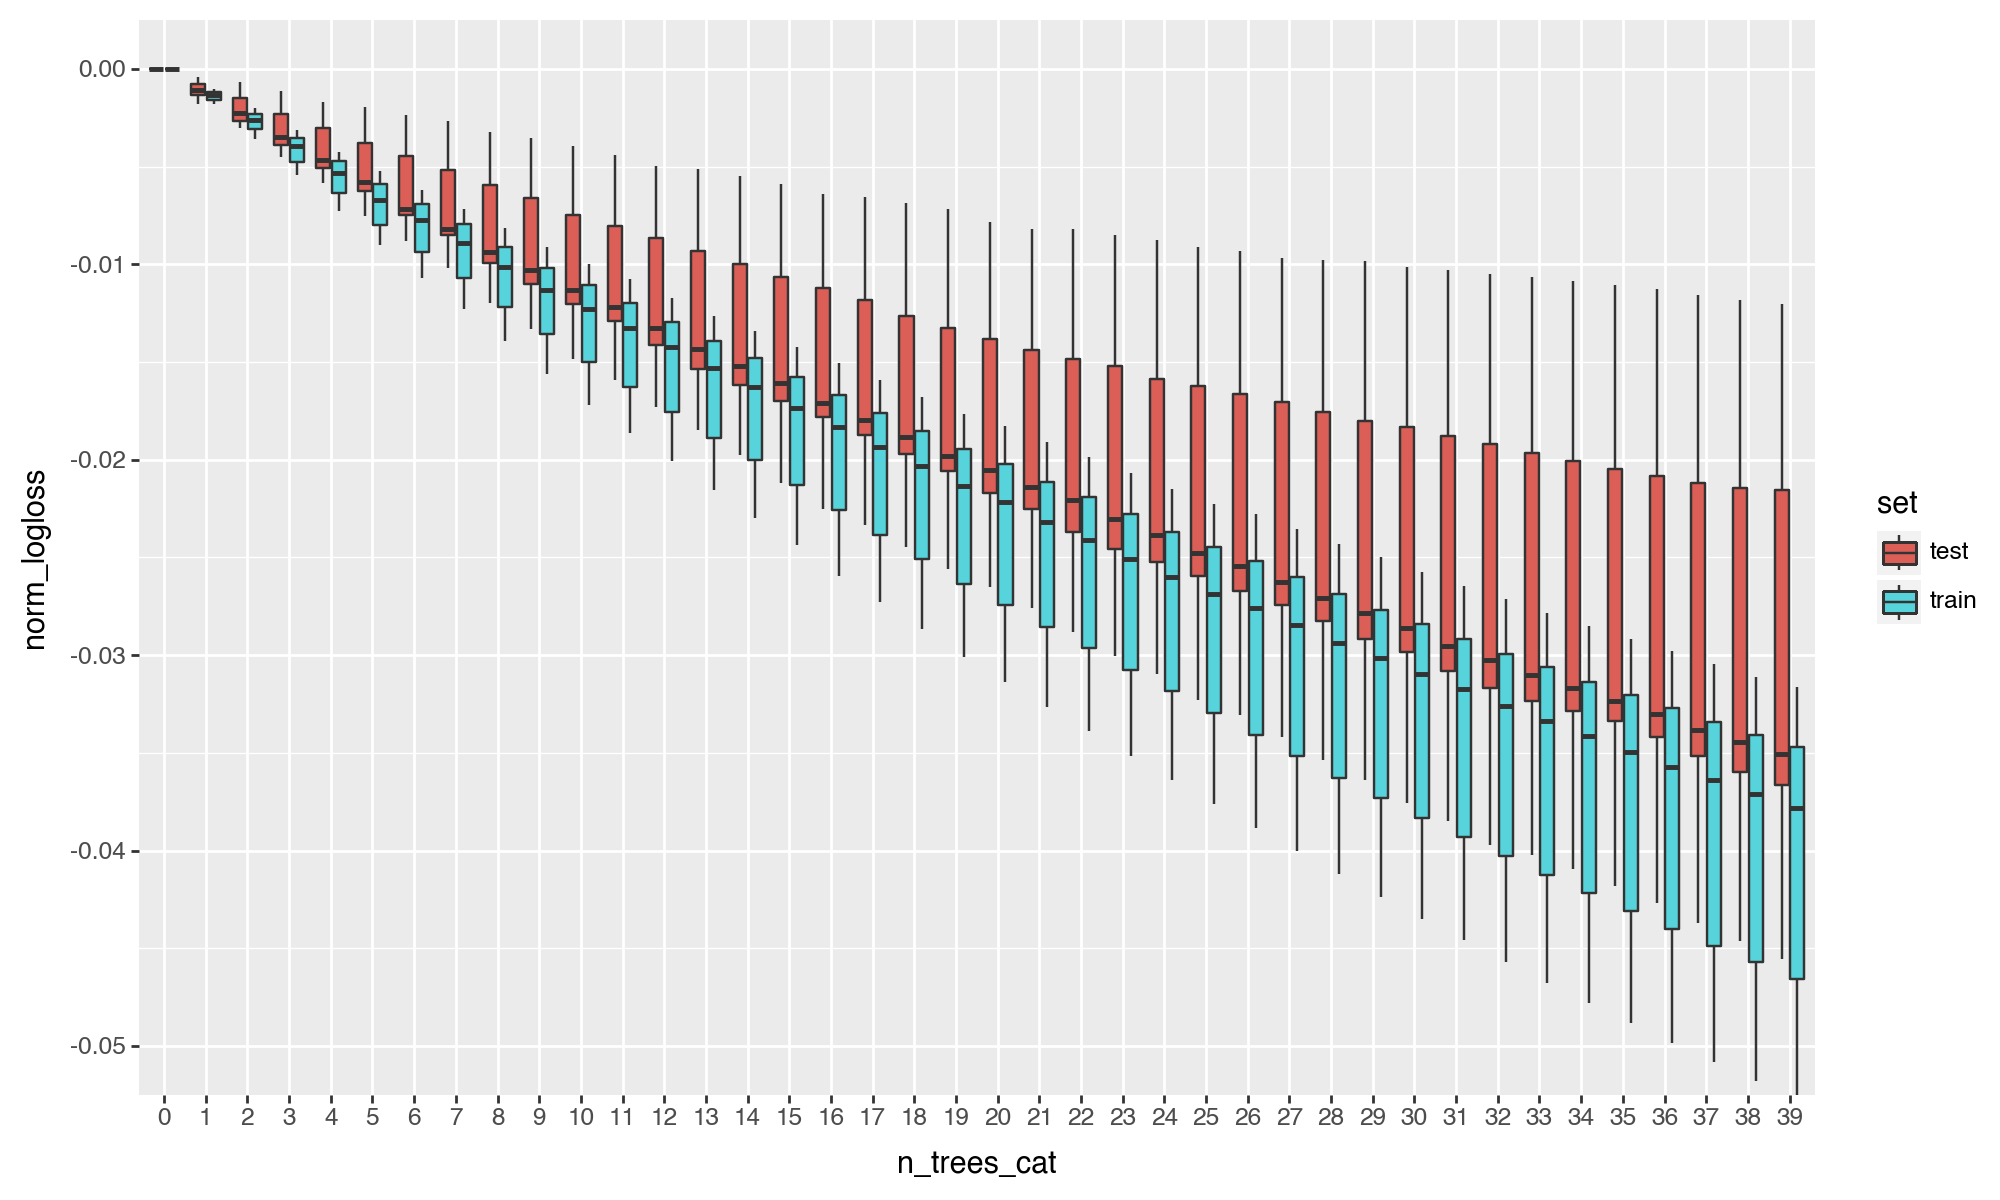

In [167]:
fig = plt.figure(figsize=(10, 6))

ggplot(
    data_lc[data_lc["n_trees"] < 40],
    aes(x="n_trees_cat", y="norm_logloss", fill="set")
) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=(-0.05, 0)) + theme(
    figure_size=(10, 6)
)

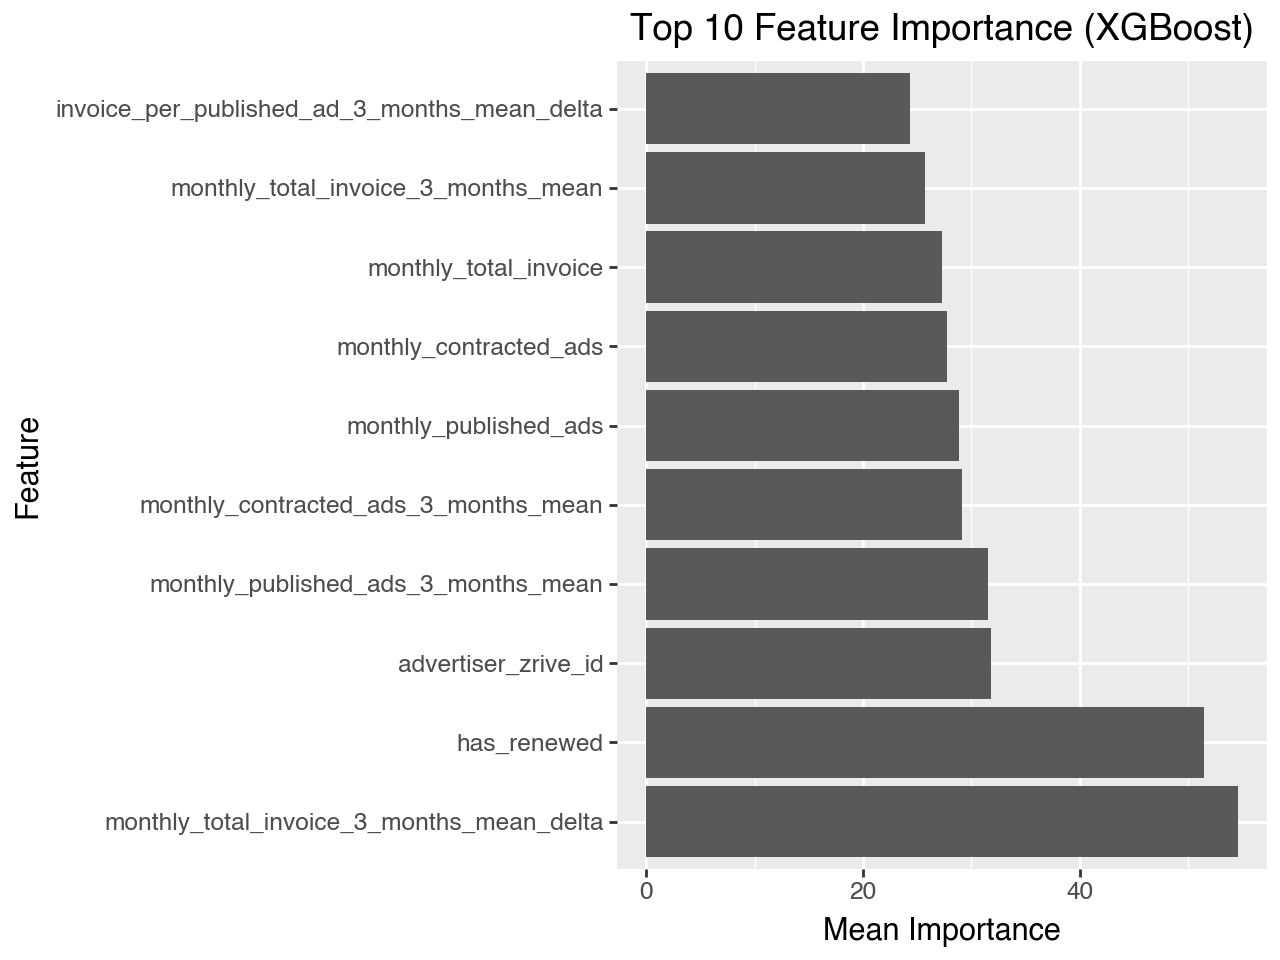

In [168]:
final_importance_df = final_importance_df.sort_values(["execution_date", "importance"], ascending=[False, False])

importance_summary = (
    final_importance_df
    .groupby("feature")["importance"]
    .mean()
    .reset_index()
)

top_features = (
    importance_summary
    .sort_values("importance", ascending=False)
    .head(10)
)

(
    ggplot(top_features) +
    geom_col(aes(x="feature", y="importance")) +
    coord_flip() +
    scale_x_discrete(limits=top_features["feature"].tolist()) +
    labs(title="Top 10 Feature Importance (XGBoost)", x="Feature", y="Mean Importance")
)
